In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
#Metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
from sklearn.metrics import zero_one_loss
from sklearn.metrics import matthews_corrcoef
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.layers import Input


In [ ]:
data= pd.read_excel('/content/data_combined.xlsx')

In [ ]:
Labels = data['Appointment Type'].values
Features = data.drop(['Appointment Type'],axis=1).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, stratify=Labels, random_state=42)

print('Train data shape:', X_train.shape)
print('Train labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Train data shape: (19444, 12)
Train labels shape: (19444,)
Test data shape: (4862, 12)
Test labels shape: (4862,)


In [ ]:
y_train= tf.keras.utils.to_categorical(
    y_train, num_classes=2
)

In [ ]:
y_test= tf.keras.utils.to_categorical(
    y_test, num_classes=2
)

In [ ]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train=np.expand_dims(X_train, axis=-1)
X_test=np.expand_dims(X_test, axis=-1)

In [ ]:
X_train.shape

(19444, 12, 1)

In [ ]:
def evaluate_model(model, X_test, y_test, history):

    # Realizar predicciones con el modelo
    y_pred = model.predict(X_test)

    # Obtener la clase con la máxima probabilidad en las etiquetas verdaderas (y_test)
    max_prob_true = np.argmax(y_test, axis=1)

    # Obtener la clase con la máxima probabilidad en las predicciones (predict)
    max_prob_pred = np.argmax(y_pred, axis=1)

    # Calcular las métricas
    accuracy = accuracy_score(max_prob_true, max_prob_pred)
    f1 = f1_score(max_prob_true, max_prob_pred, average='weighted')
    recall = recall_score(max_prob_true, max_prob_pred, average='weighted')

    # Mostrar las métricas
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)

    # Graficar la precisión para entrenamiento y validación
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Precisión del entrenamiento
    plt.plot(history.history['val_accuracy'], label='Test Accuracy')  # Precisión de la validación
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Graficar la pérdida para entrenamiento y validación
    plt.plot(history.history['loss'], label='Train Loss')  # Pérdida del entrenamiento
    plt.plot(history.history['val_loss'], label='Test Loss')  # Pérdida de la validación
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(max_prob_true, max_prob_pred)

    # Graficar la matriz de confusión usando seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

     # Binarizar las etiquetas verdaderas para ROC multi-clase
    y_test_bin = label_binarize(y_test, classes=np.arange(y_pred.shape[1]))

    # Número de clases
    n_classes = y_pred.shape[1]

    # Inicializar las variables para la curva ROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcular fpr, tpr y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Gráfica ROC para cada clase
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    # Agregar la línea de referencia
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

    # Etiquetas y título del gráfico
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

#CNN Simple

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.5056 - loss: 0.7037 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5172 - loss: 0.6922 - val_accuracy: 0.5267 - val_loss: 0.6905
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5427 - loss: 0.6847 - val_accuracy: 0.5465 - val_loss: 0.6851
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5780 - loss: 0.6740 - val_accuracy: 0.5549 - val_loss: 0.6772
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6096 - loss: 0.6628 - val_accuracy: 0.6098 - val_loss: 0.6581
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6340 - loss: 0.6448 - val_accuracy: 0.6403 - val_loss: 0.6400
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6545 - loss: 0.6242 - val_accuracy: 0.6789 - val_loss: 0.6175
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6566 - loss: 0.6168 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7521596051007816
F1 Score: 0.7521067421375889
Recall: 0.7521596051007816


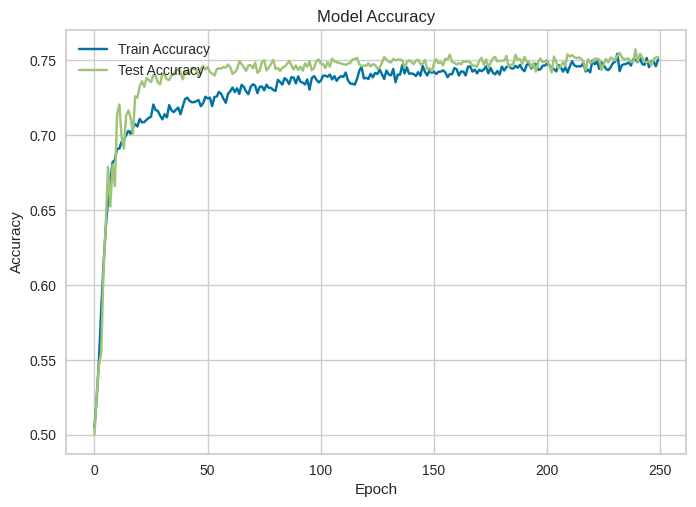

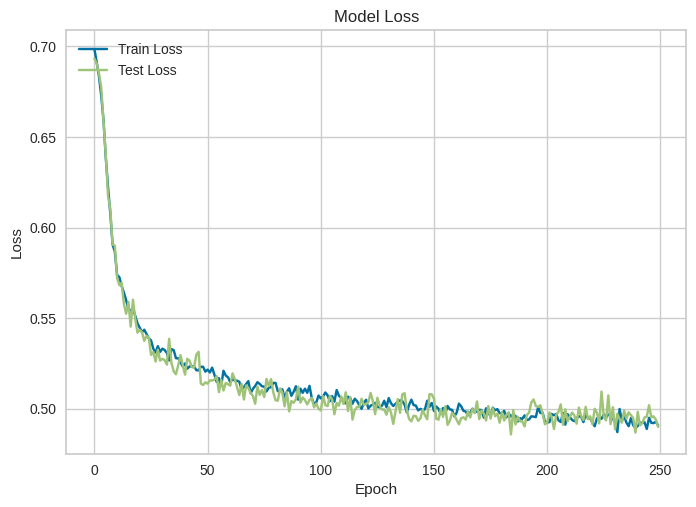

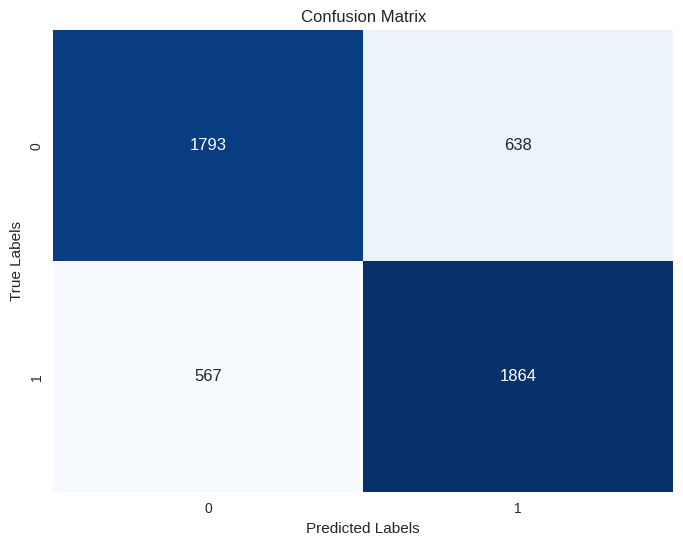

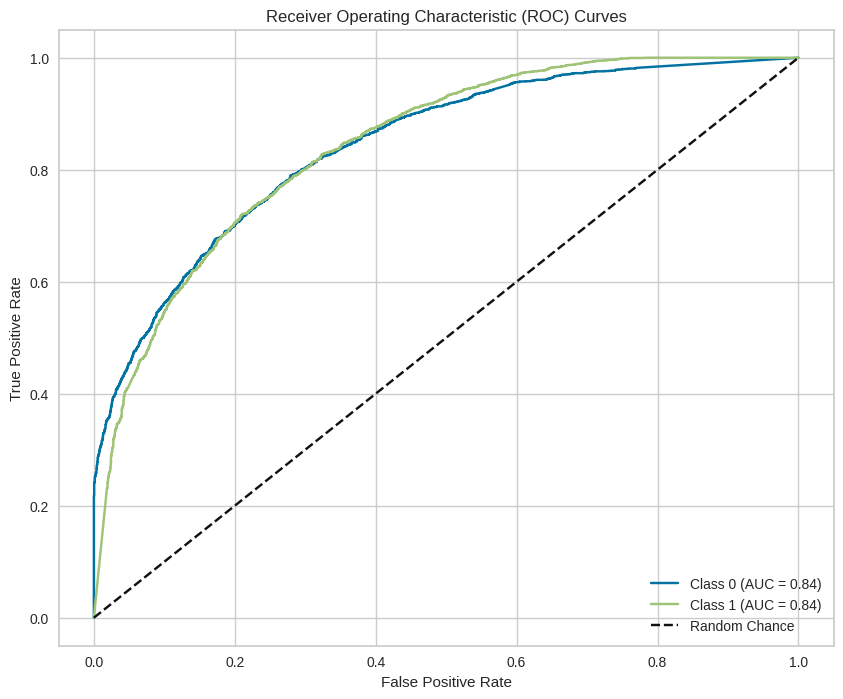

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN 2: Una capa mas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.5032 - loss: 0.7032 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5261 - loss: 0.6906 - val_accuracy: 0.5027 - val_loss: 0.6952
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5538 - loss: 0.6836 - val_accuracy: 0.5062 - val_loss: 0.6957
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5819 - loss: 0.6756 - val_accuracy: 0.5465 - val_loss: 0.6836
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6060 - loss: 0.6654 - val_accuracy: 0.5309 - val_loss: 0.6865
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6181 - loss: 0.6538 - val_accuracy: 0.5496 - val_loss: 0.6842
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6270 - loss: 0.6467 - val_accuracy: 0.5650 - val_loss: 0.6780
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6252 - loss: 0.6427 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7344714109419992
F1 Score: 0.7307314683397742
Recall: 0.7344714109419992


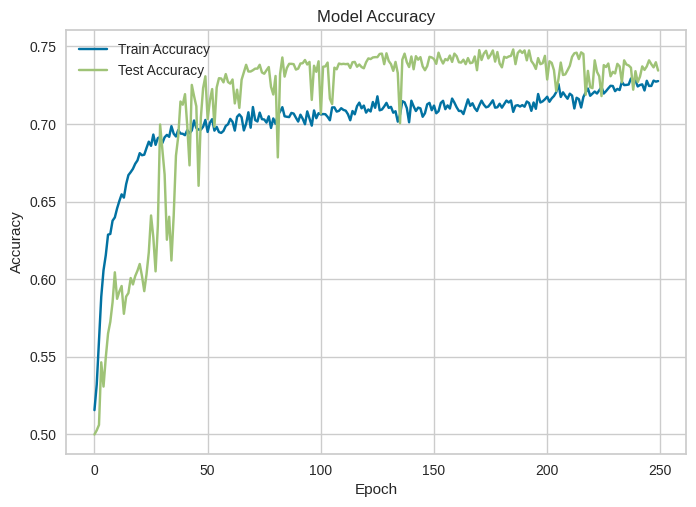

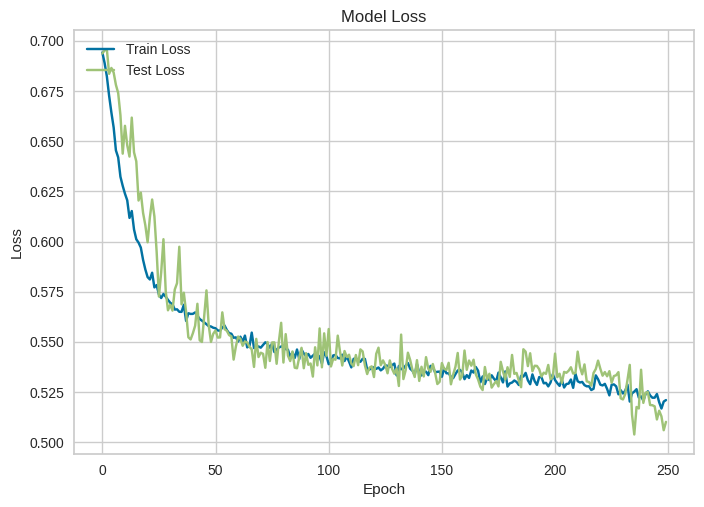

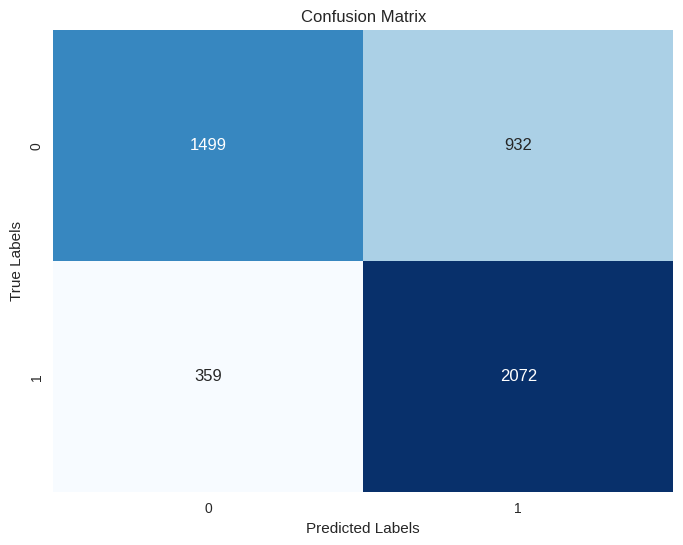

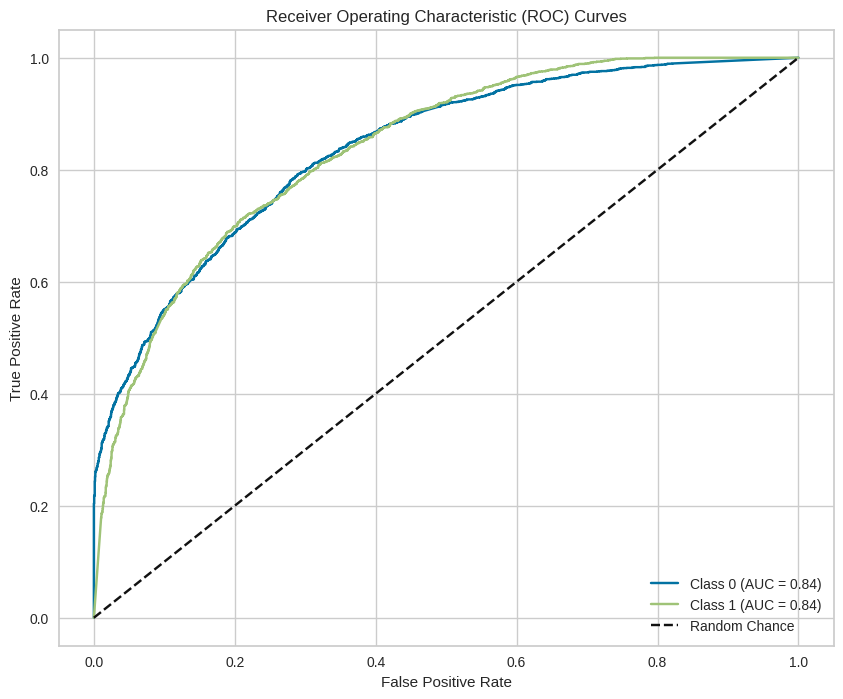

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN 3: Más profunda

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 3
x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

#ANN
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.5089 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 0.6941
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5239 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5326 - loss: 0.6885 - val_accuracy: 0.5292 - val_loss: 0.6891
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5672 - loss: 0.6792 - val_accuracy: 0.5224 - val_loss: 0.6896
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5845 - loss: 0.6732 - val_accuracy: 0.5481 - val_loss: 0.6845
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6084 - loss: 0.6572 - val_accuracy: 0.5619 - val_loss: 0.6792
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6168 - loss: 0.6532 - val_accuracy: 0.5784 - val_loss: 0.6680
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6157 - loss: 0.6523 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Accuracy: 0.7354997943233237
F1 Score: 0.7336608531975954
Recall: 0.7354997943233237


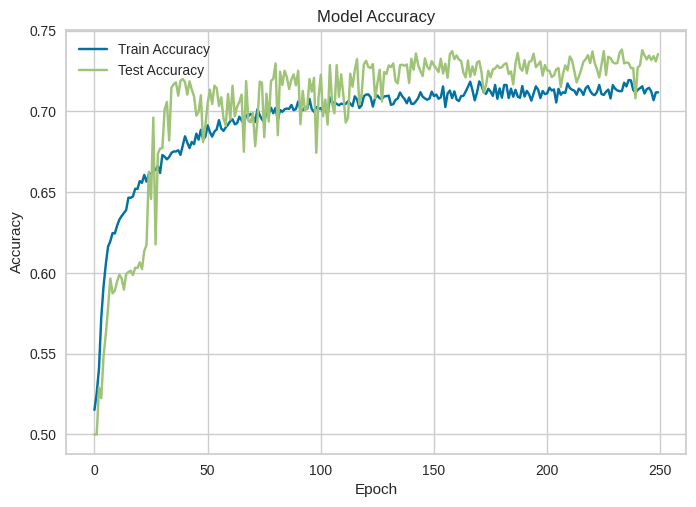

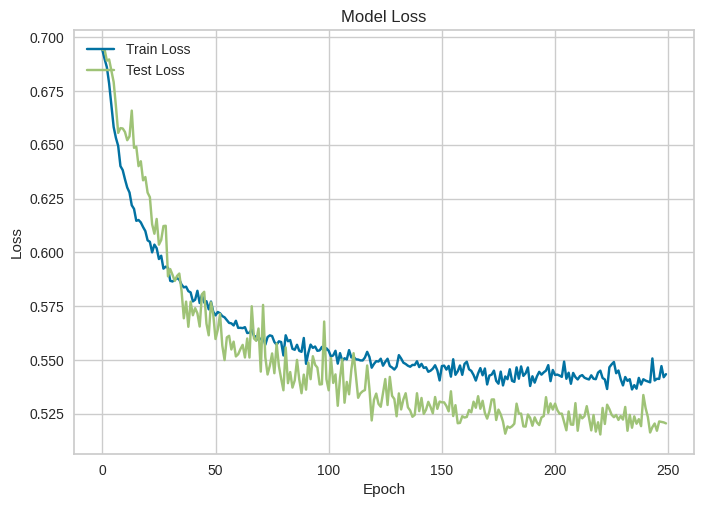

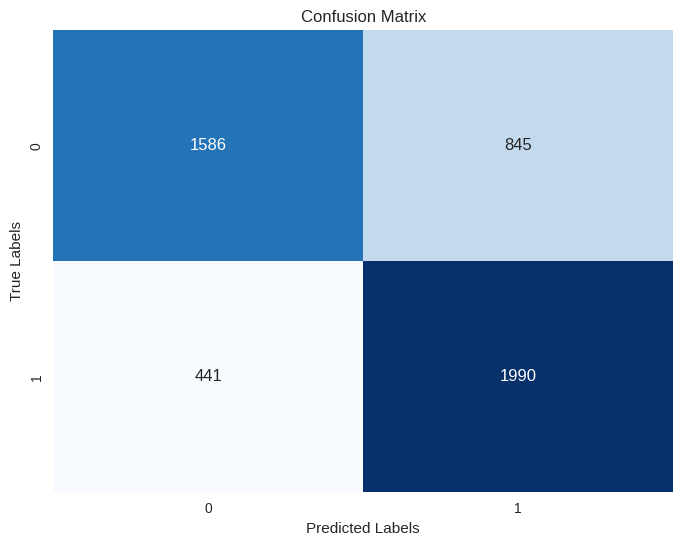

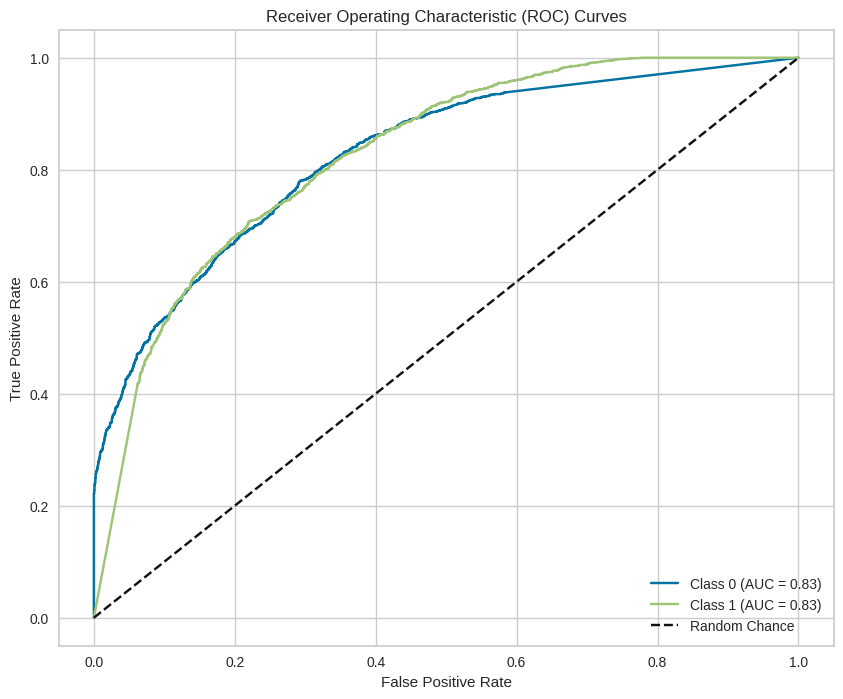

In [ ]:
evaluate_model(model, X_test, y_test, history)

##CNN: Intentando mejorar la mejor profunda con mas capas internas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - accuracy: 0.5117 - loss: 0.6944 - val_accuracy: 0.5138 - val_loss: 0.6914
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5581 - loss: 0.6838 - val_accuracy: 0.5469 - val_loss: 0.6851
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6075 - loss: 0.6627 - val_accuracy: 0.5638 - val_loss: 0.6750
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6133 - loss: 0.6542 - val_accuracy: 0.5967 - val_loss: 0.6609
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6279 - loss: 0.6417 - val_accuracy: 0.6076 - val_loss: 0.6386
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6376 - loss: 0.6284 - val_accuracy: 0.6030 - val_loss: 0.6389
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6482 - loss: 0.6161 - val_accuracy: 0.6004 - val_loss: 0.6334
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6566 - loss: 0.6089 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Accuracy: 0.735088440970794
F1 Score: 0.7350453560790685
Recall: 0.735088440970794


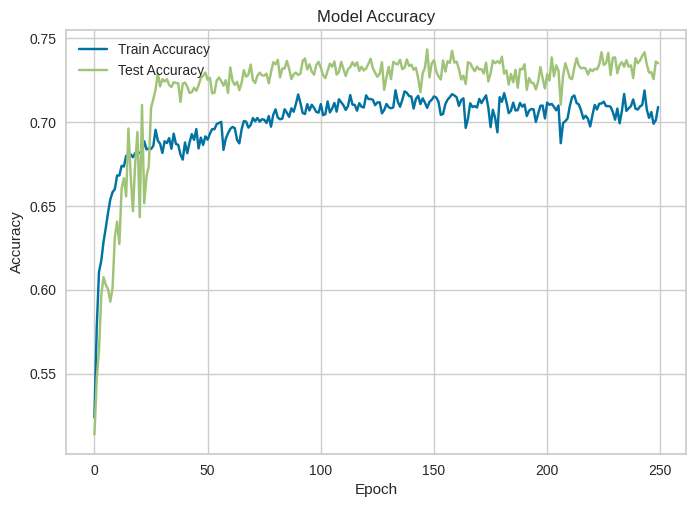

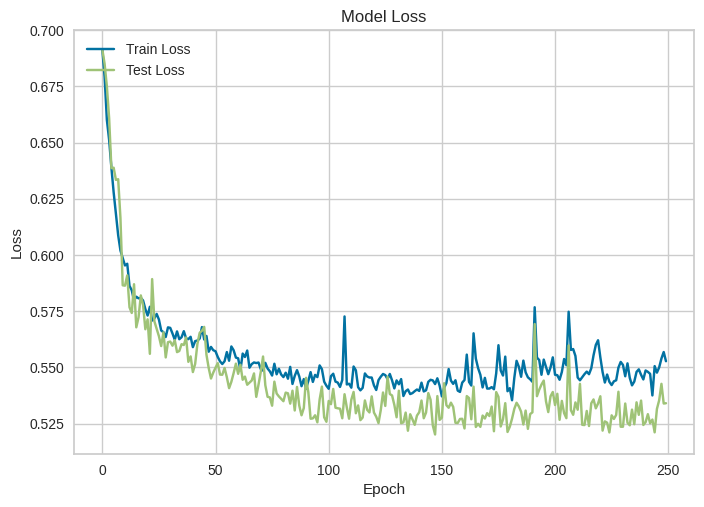

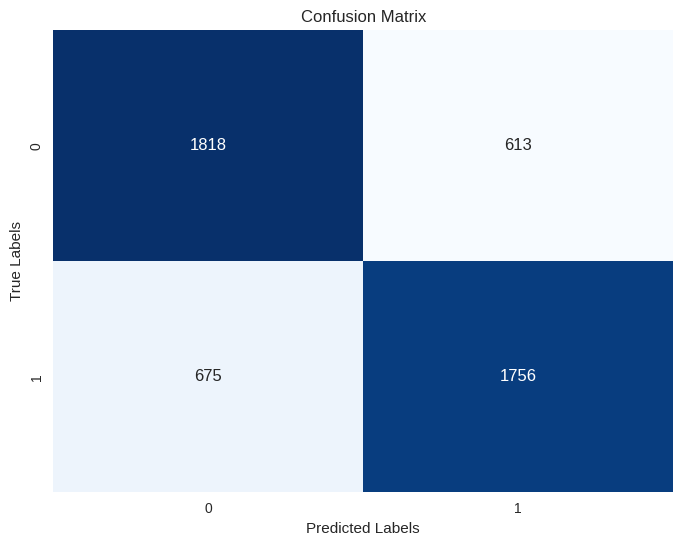

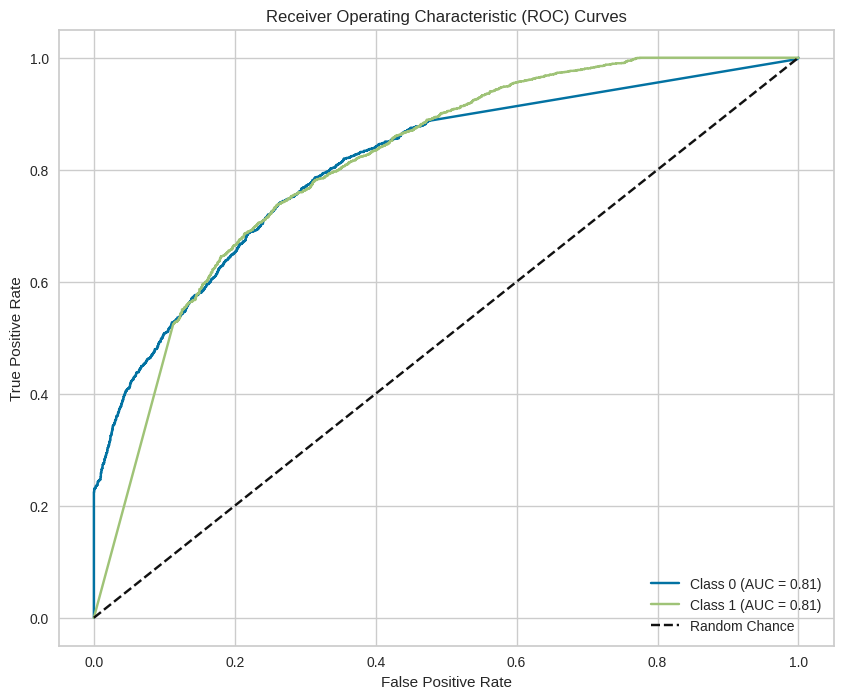

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Intentando mejorar la mejor CNN con más capas internas

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 23s 69ms/step - accuracy: 0.5099 - loss: 0.7018 - val_accuracy: 0.5025 - val_loss: 0.6929
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5232 - loss: 0.6921 - val_accuracy: 0.5136 - val_loss: 0.6918
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5639 - loss: 0.6833 - val_accuracy: 0.5370 - val_loss: 0.6859
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6059 - loss: 0.6661 - val_accuracy: 0.5864 - val_loss: 0.6654
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6375 - loss: 0.6414 - val_accuracy: 0.6236 - val_loss: 0.6335
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6595 - loss: 0.6173 - val_accuracy: 0.6094 - val_loss: 0.6275
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6613 - loss: 0.6022 - val_accuracy: 0.6366 - val_loss: 0.6000
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6681 - loss: 0.5921 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7445495680789799
F1 Score: 0.744015878075911
Recall: 0.7445495680789799


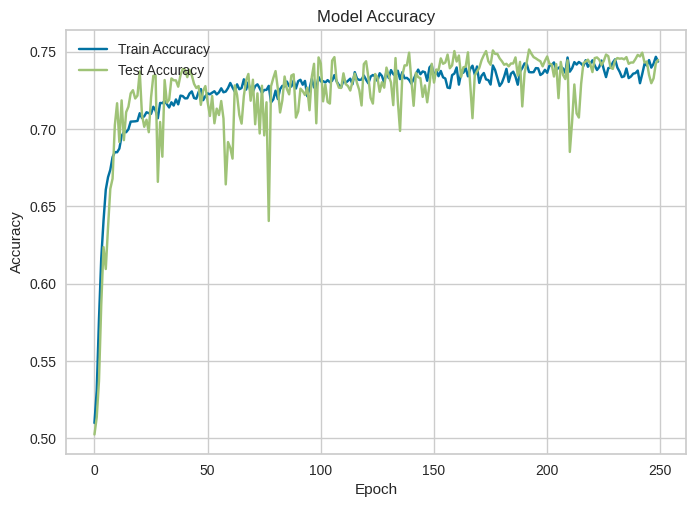

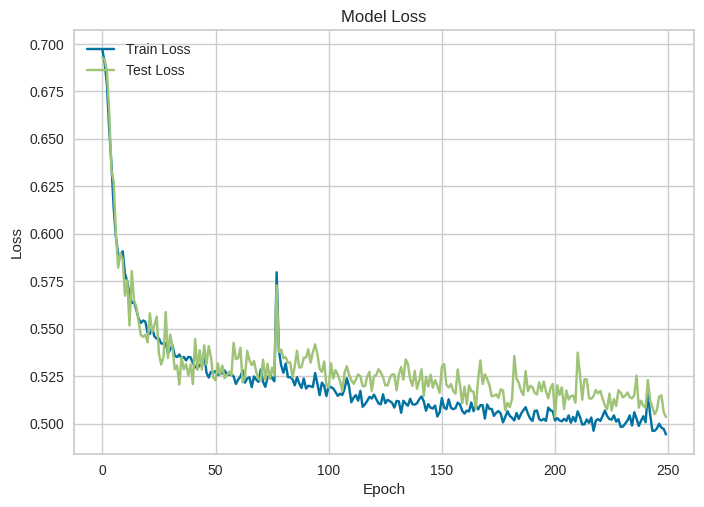

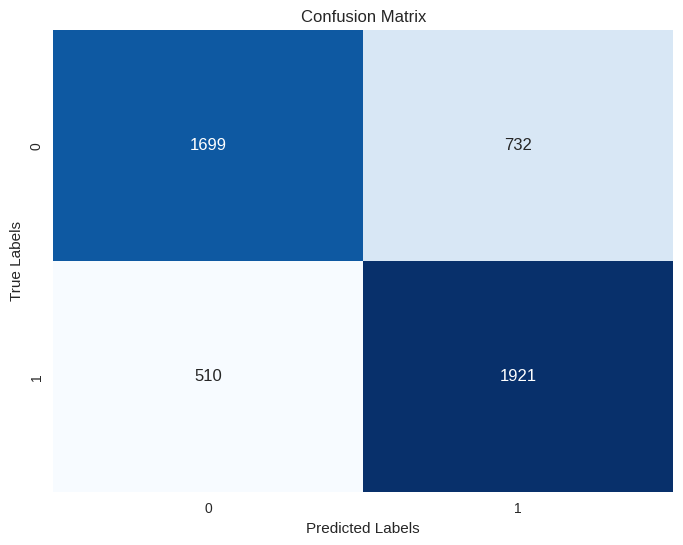

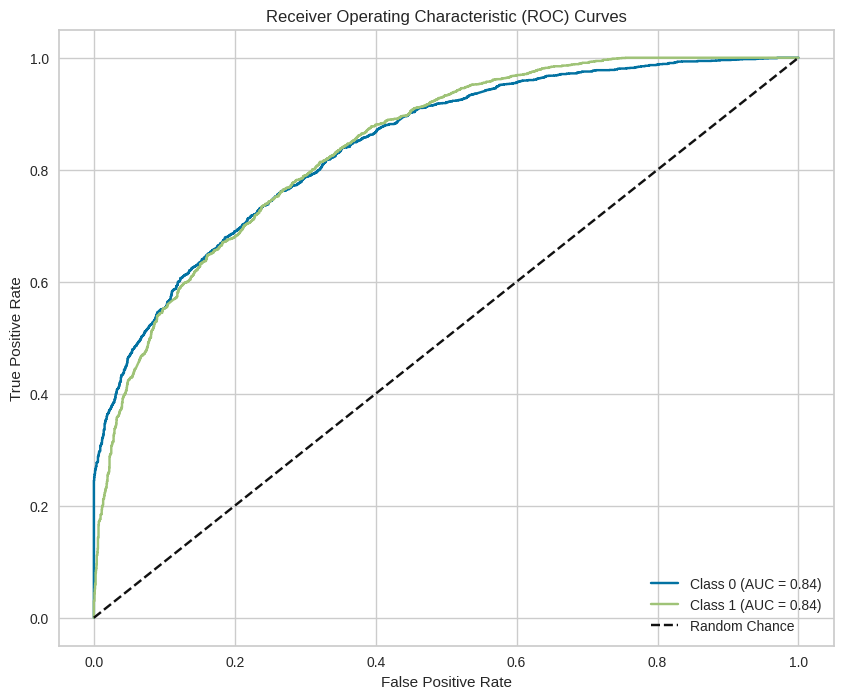

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Variando el kernel a la mejor CNN: K=5

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.4969 - loss: 0.7232 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4964 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5072 - loss: 0.6939 - val_accuracy: 0.5119 - val_loss: 0.6920
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5312 - loss: 0.6895 - val_accuracy: 0.5348 - val_loss: 0.6897
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5735 - loss: 0.6805 - val_accuracy: 0.6035 - val_loss: 0.6721
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6250 - loss: 0.6620 - val_accuracy: 0.6207 - val_loss: 0.6624
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6461 - loss: 0.6493 - val_accuracy: 0.6107 - val_loss: 0.6561
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6556 - loss: 0.6366 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7527766351295763
F1 Score: 0.7527224075965585
Recall: 0.7527766351295763


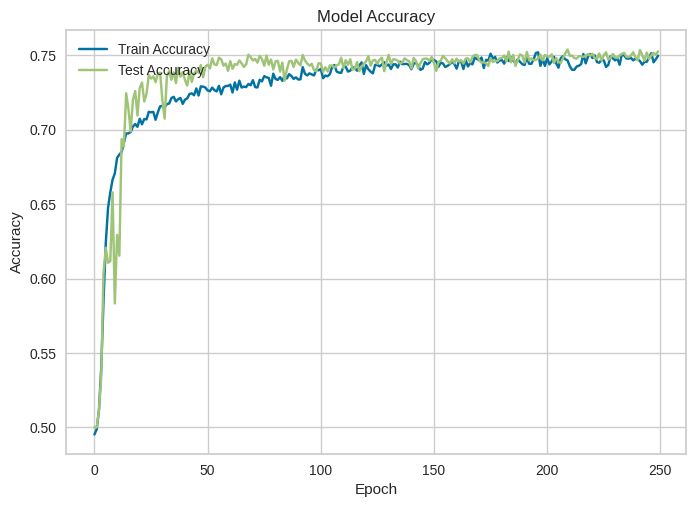

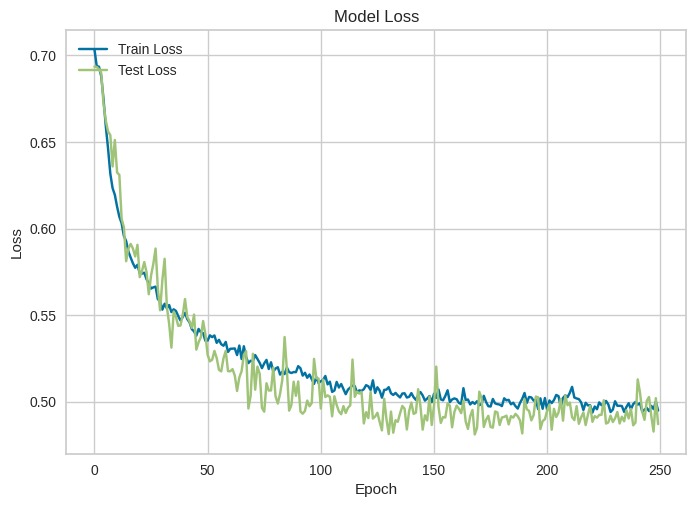

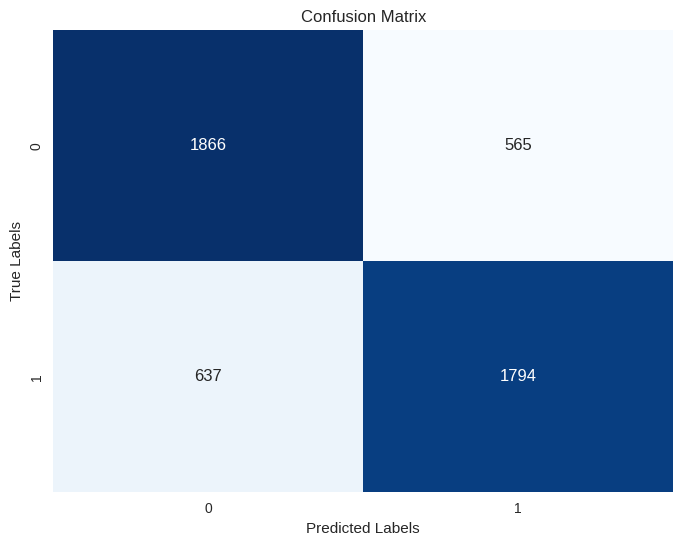

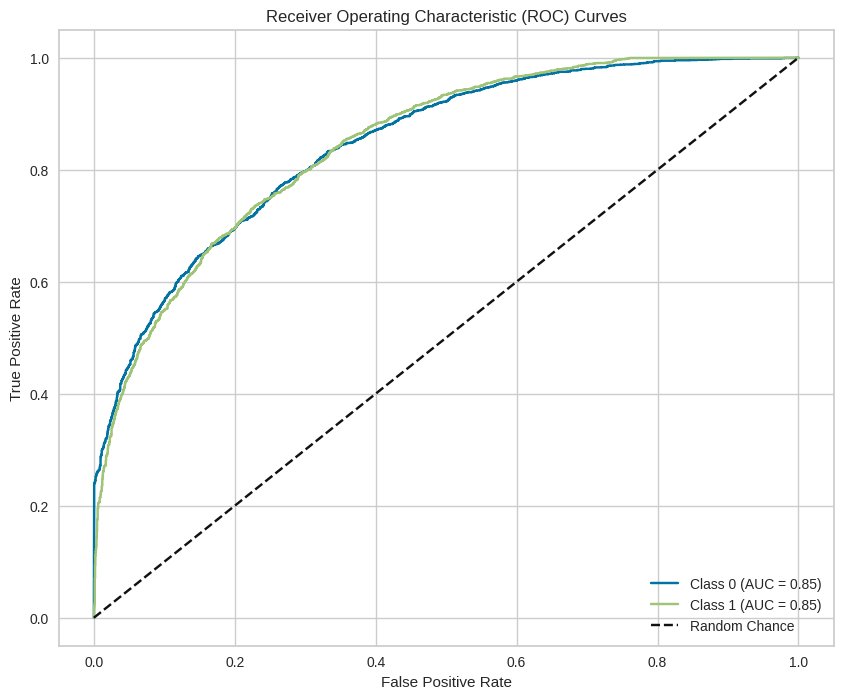

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Kernel =7

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.5144 - loss: 0.6943 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5262 - loss: 0.6907 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5646 - loss: 0.6816 - val_accuracy: 0.5286 - val_loss: 0.6874
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5992 - loss: 0.6677 - val_accuracy: 0.5697 - val_loss: 0.6719
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6250 - loss: 0.6547 - val_accuracy: 0.6063 - val_loss: 0.6513
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6445 - loss: 0.6312 - val_accuracy: 0.5862 - val_loss: 0.6551
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6623 - loss: 0.6120 - val_accuracy: 0.6310 - val_loss: 0.6102
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6809 - loss: 0.5972 - val_ac

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.7538050185109009
F1 Score: 0.7529916447814655
Recall: 0.7538050185109009


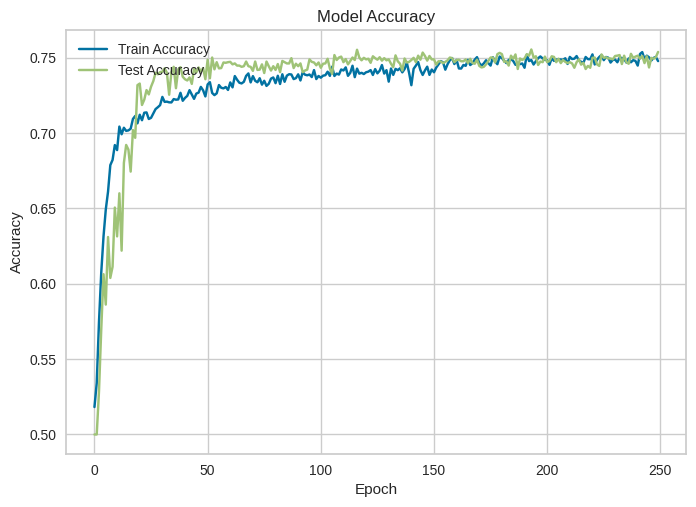

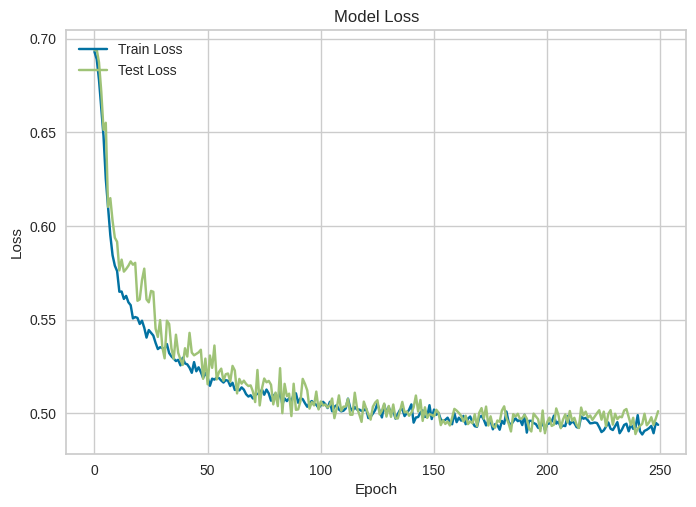

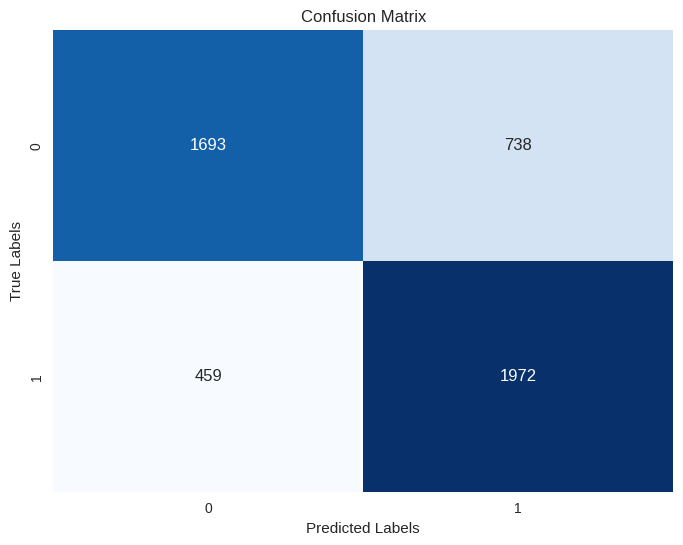

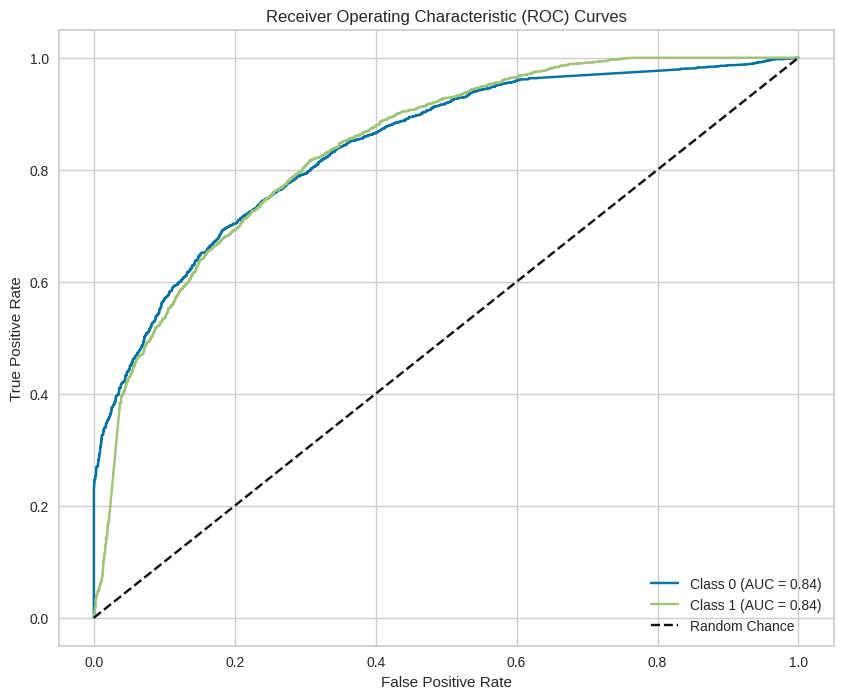

In [ ]:
evaluate_model(model, X_test, y_test, history)

In [ ]:
import numpy as np
# Matriz de confusión
confusion_matrix_values = np.array([
    [1693, 738],
    [459, 1972]
])

# Calcular la matriz de confusión en porcentaje por filas
conf_matrix_percent = confusion_matrix_values.astype('float') / confusion_matrix_values.sum(axis=1)[:, np.newaxis] * 100

# Mostrar la matriz en porcentajes
print(conf_matrix_percent)

[[69.64212258 30.35787742]
 [18.88111888 81.11888112]]


##Mejorando la red anterior

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

x = tf.keras.layers.Flatten()(x)

# ANN
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step - accuracy: 0.4982 - loss: 0.6986 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.4903 - loss: 0.6935 - val_accuracy: 0.5019 - val_loss: 0.6932
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5090 - loss: 0.6935 - val_accuracy: 0.5021 - val_loss: 0.6932
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5113 - loss: 0.6924 - val_accuracy: 0.5218 - val_loss: 0.6918
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5447 - loss: 0.6864 - val_accuracy: 0.5810 - val_loss: 0.6786
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6016 - loss: 0.6664 - val_accuracy: 0.5500 - val_loss: 0.6825
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6230 - loss: 0.6502 - val_accuracy: 0.6228 - val_loss: 0.6477
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6307 - loss: 0.6477 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.7313862607980255
F1 Score: 0.7272322695038508
Recall: 0.7313862607980255


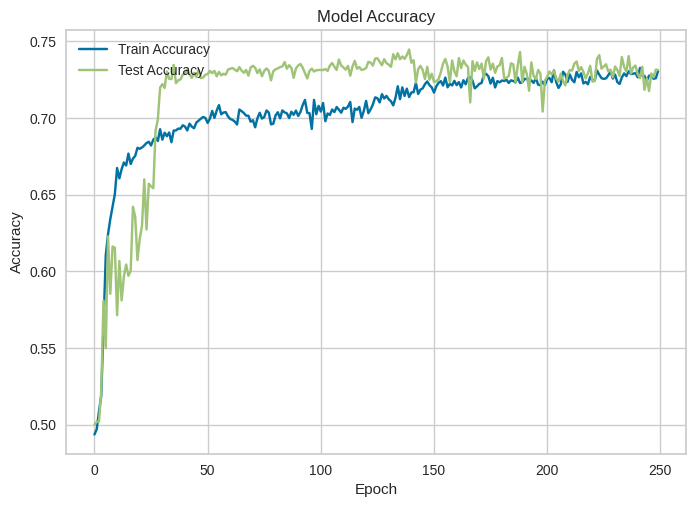

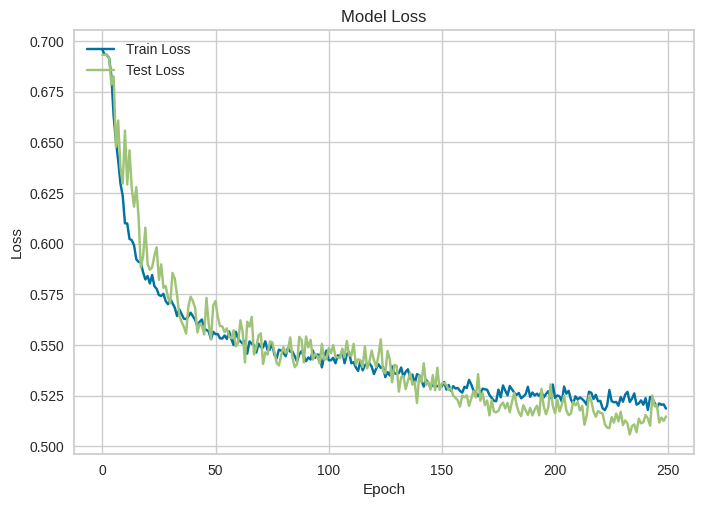

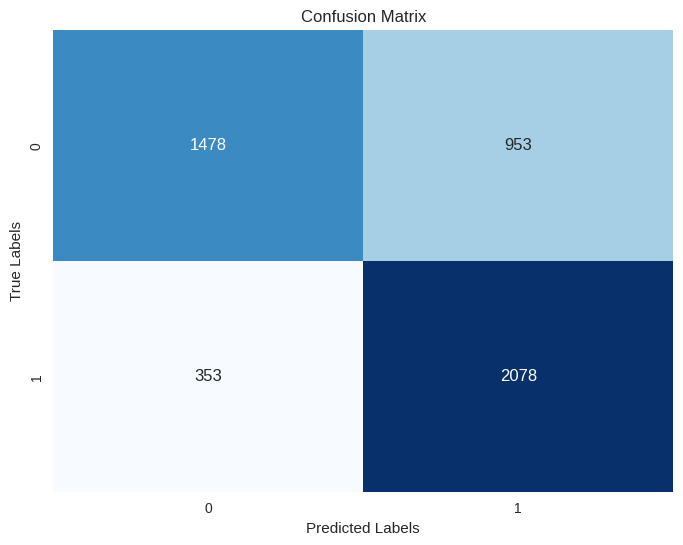

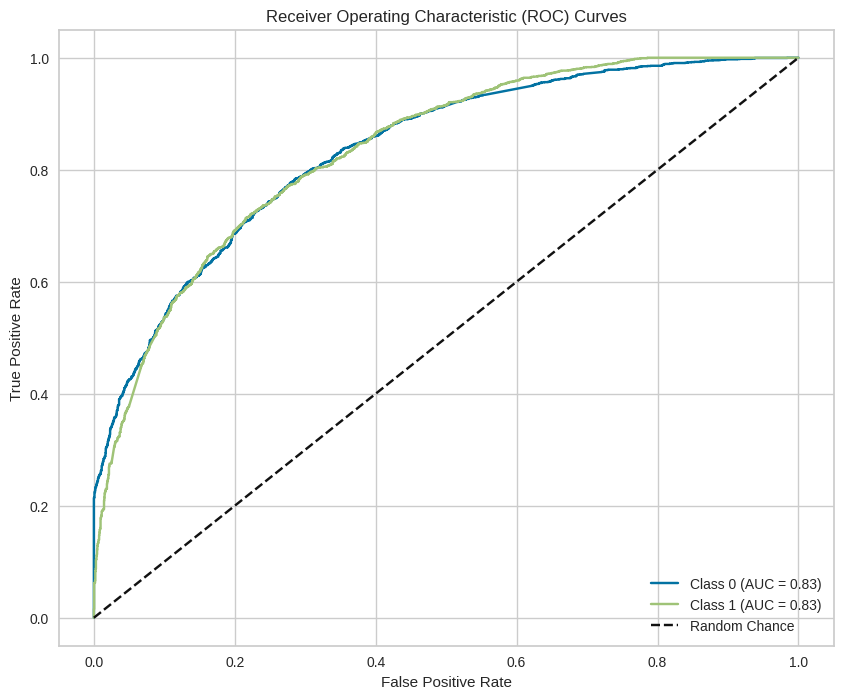

In [ ]:
evaluate_model(model, X_test, y_test, history)

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

#Capa 1
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)

#Capa 2
x = tf.keras.layers.Conv1D(filters=64, kernel_size=7, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)


#Capa 3
x = tf.keras.layers.Conv1D(filters=128, kernel_size=7, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

#ANN
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.5113 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.5235 - loss: 0.6916 - val_accuracy: 0.5012 - val_loss: 0.6941
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5642 - loss: 0.6820 - val_accuracy: 0.5212 - val_loss: 0.6907
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6035 - loss: 0.6673 - val_accuracy: 0.5983 - val_loss: 0.6684
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6283 - loss: 0.6491 - val_accuracy: 0.6460 - val_loss: 0.6492
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6391 - loss: 0.6411 - val_accuracy: 0.6380 - val_loss: 0.6484
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6446 - loss: 0.6323 - val_accuracy: 0.6598 - val_loss: 0.6420
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6431 - loss: 0.6233 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.7176059234882765
F1 Score: 0.7106659208864757
Recall: 0.7176059234882765


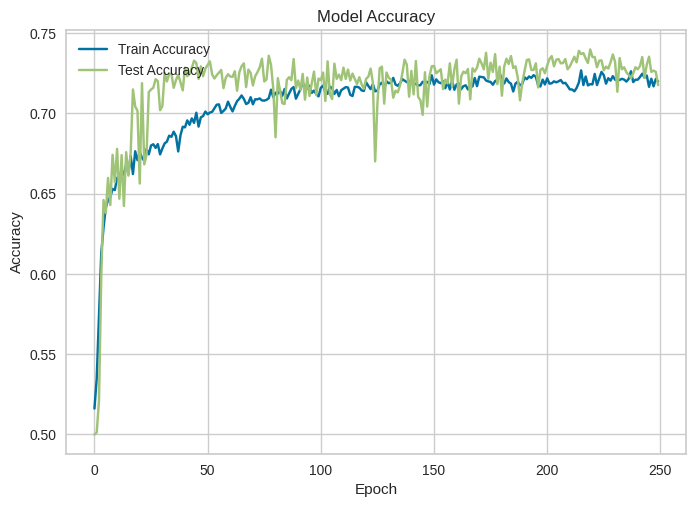

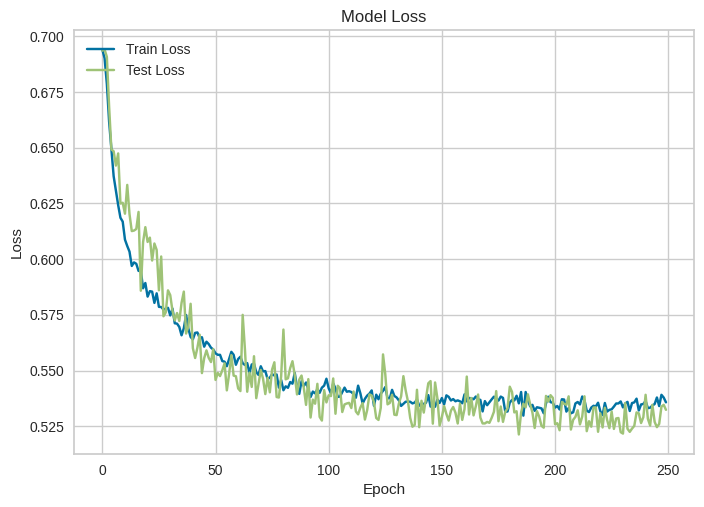

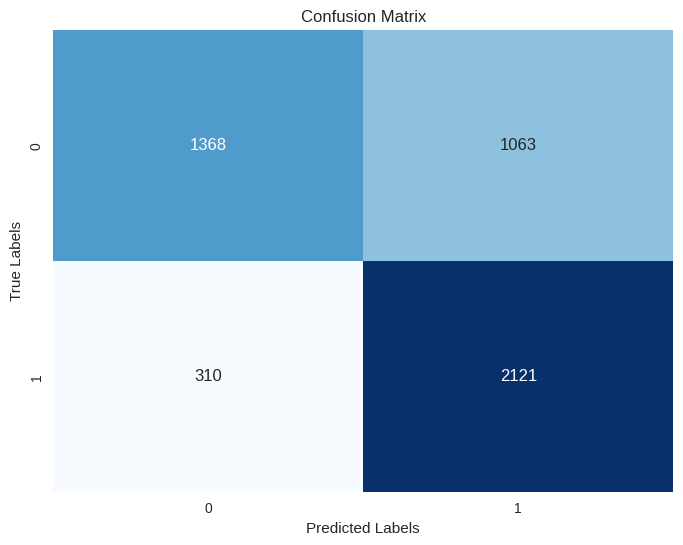

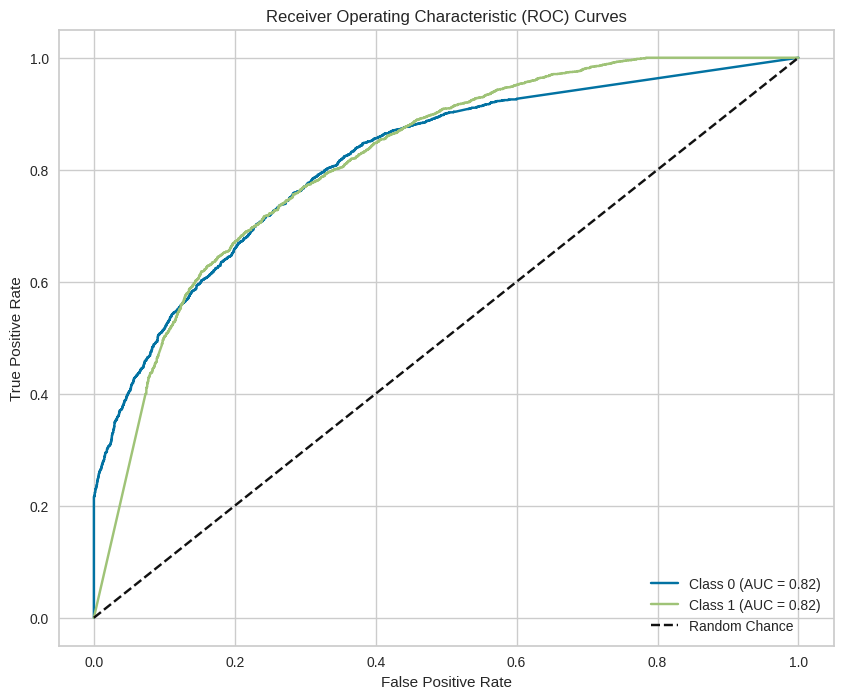

In [ ]:
evaluate_model(model, X_test, y_test, history)

##Ultima red

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=250, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.5176 - loss: 0.7030 - val_accuracy: 0.5090 - val_loss: 0.6927
Epoch 2/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.5323 - loss: 0.6907 - val_accuracy: 0.5041 - val_loss: 0.6937
Epoch 3/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5699 - loss: 0.6788 - val_accuracy: 0.5574 - val_loss: 0.6812
Epoch 4/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6086 - loss: 0.6584 - val_accuracy: 0.6067 - val_loss: 0.6653
Epoch 5/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6394 - loss: 0.6310 - val_accuracy: 0.6401 - val_loss: 0.6300
Epoch 6/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6509 - loss: 0.6126 - val_accuracy: 0.6318 - val_loss: 0.6069
Epoch 7/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6664 - loss: 0.5913 - val_accuracy: 0.6242 - val_loss: 0.6035
Epoch 8/250
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6818 - loss: 0.5819 - val_a

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Accuracy: 0.7338543809132044
F1 Score: 0.7271524476980189
Recall: 0.7338543809132044


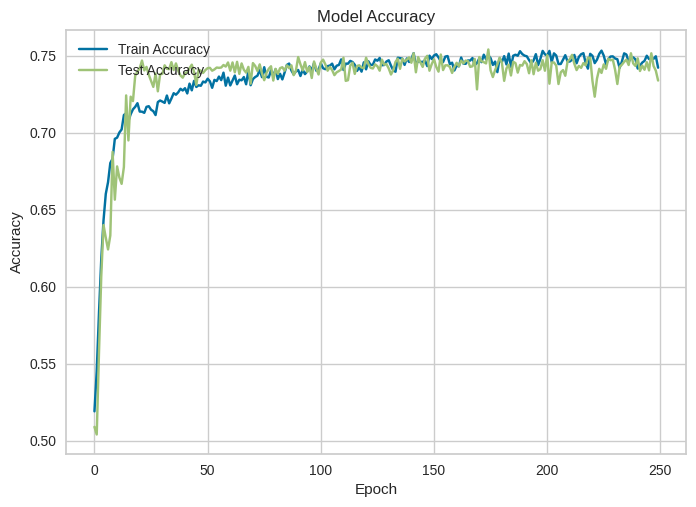

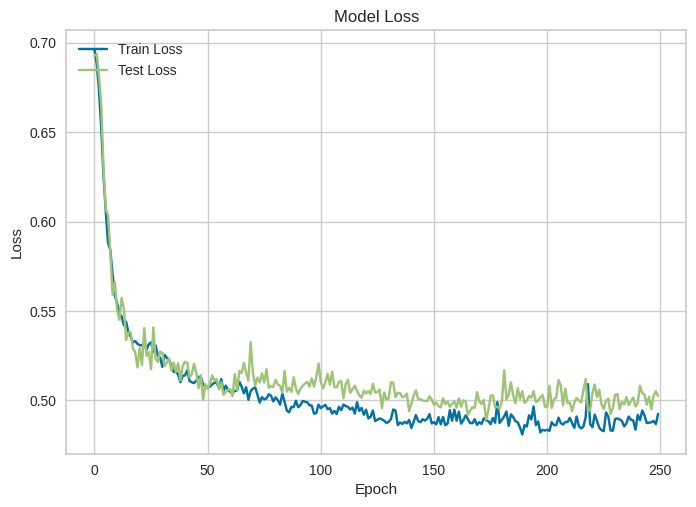

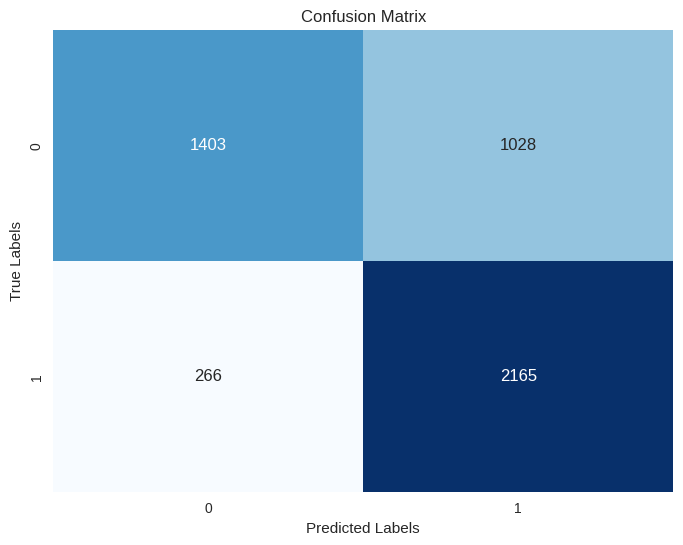

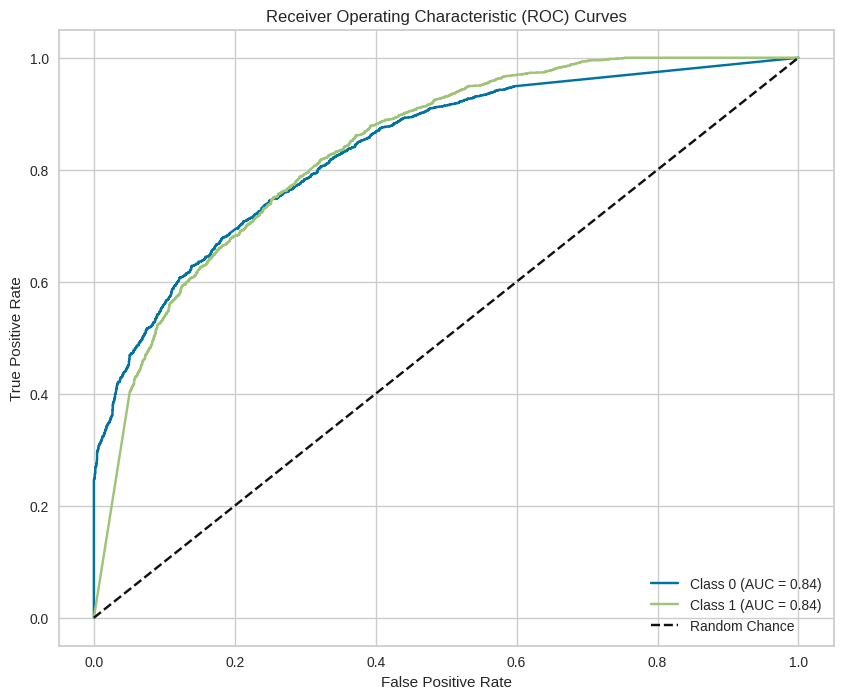

In [ ]:
evaluate_model(model, X_test, y_test, history)

##MEJOR RED CNN

In [ ]:
import tensorflow as tf

inputs = Input(shape=(X_train.shape[1],1), name="inputs")

# CNN 1D
x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, strides=1, padding='same')(inputs)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)
x=  tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Flatten()(x)

# Asume que `x` viene de una CNN o de otra parte del modelo
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(12, activation='relu')(x)

# Capa de salida con 2 clases (softmax para clasificación)
output = tf.keras.layers.Dense(2, activation='softmax')(x)

# Construir el modelo final
model = tf.keras.models.Model(inputs=inputs, outputs=output)

# Definir tasa de aprendizaje y optimizador
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

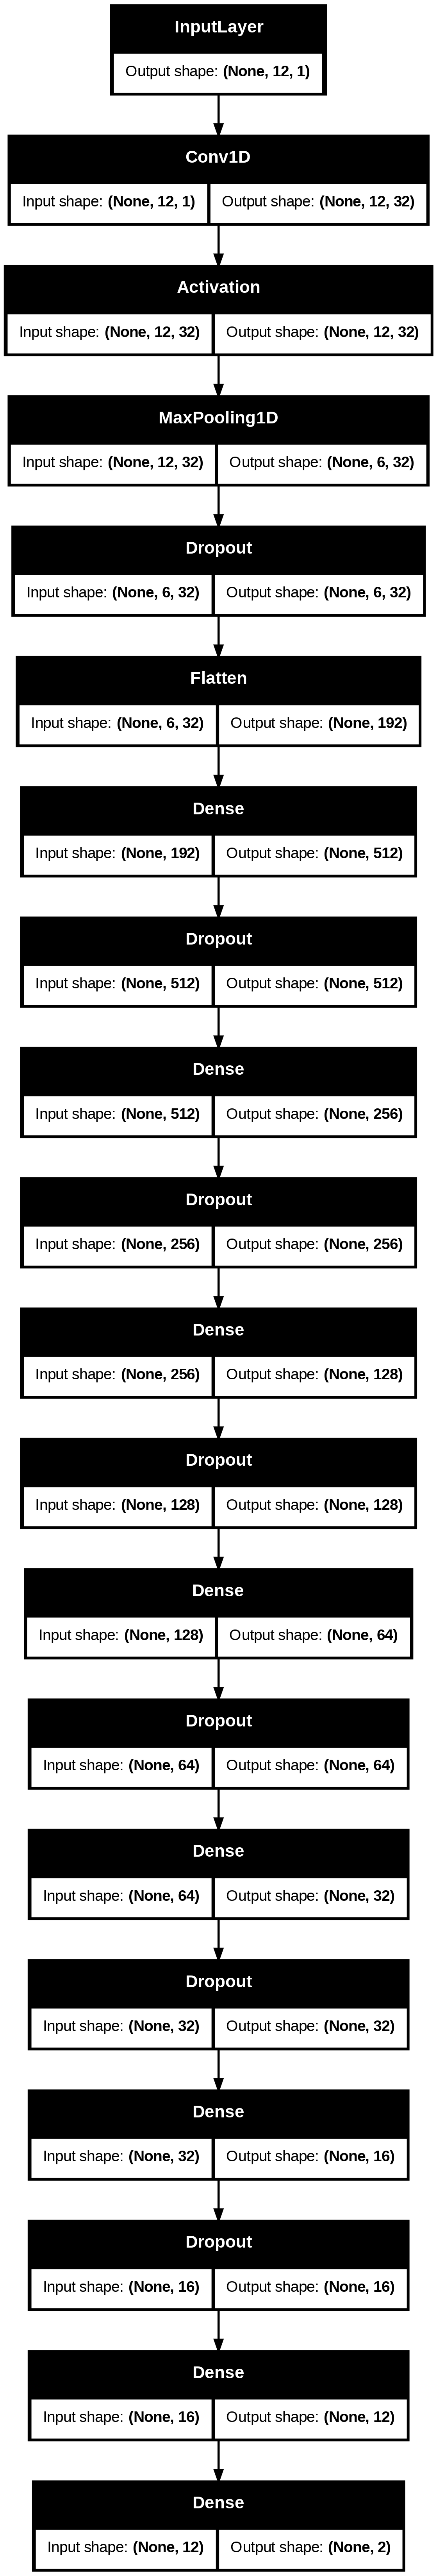

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)